# Download dataset

In [1]:
import datasets
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
if os.path.exists("wikipedia_dataset"):
    dataset = datasets.load_from_disk("wikipedia_dataset")
else:
    dataset = datasets.load_dataset("wikipedia", "20220301.en")
    dataset.save_to_disk("wikipedia_dataset")

dataset = dataset["train"]
print(dataset)

Loading dataset from disk:   0%|          | 0/41 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'url', 'title', 'text'],
    num_rows: 6458670
})


In [ ]:

text_lengths = [len(dataset[i]["text"]) for i in tqdm(range(0, len(dataset)))]
text_lengths = np.array(text_lengths)
scipy.stats.describe(text_lengths)

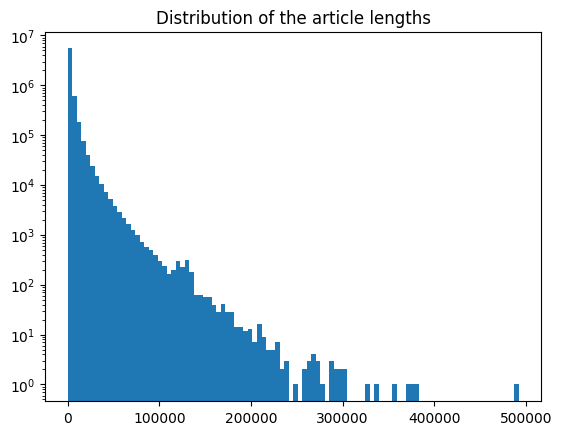

In [37]:
plt.hist(text_lengths, bins=100)
plt.yscale('log')
plt.title("Distribution of the article lengths")
plt.show()

# Split document

In [3]:
import langchain
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import TokenTextSplitter
from langchain_community.document_loaders  import HuggingFaceDatasetLoader

In [5]:
small_dataset = dataset.select(range(0, 100000))

In [6]:
#Convert HuggingFace dataset to LangChain document
documents = [
    Document(page_content=doc["text"], metadata={"id": doc["id"], "url": doc["url"], "title": doc["title"]}) for doc in tqdm(
        small_dataset)
]

100%|██████████| 100000/100000 [00:26<00:00, 3760.31it/s]


In [8]:
text_splitter = TokenTextSplitter(chunk_size=200, chunk_overlap=25, add_start_index=True)

all_splits = []
for document in tqdm(documents, desc="Splitting Documents", unit="doc"):
    splits = text_splitter.split_documents([document])
    all_splits.extend(splits)

Splitting Documents: 100%|██████████| 100000/100000 [05:53<00:00, 282.62doc/s]


In [20]:
print(len(all_splits))

1615761


# Vector database

In [9]:
from langchain_community.embeddings import FakeEmbeddings
from langchain_milvus import Milvus

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

In [10]:
embeddings = FakeEmbeddings(size=256)

In [30]:
client = QdrantClient(path="./qdrant_database2")

client.create_collection(
    collection_name="collection_1",
    vectors_config=VectorParams(size=256, distance=Distance.COSINE),
)

True

In [31]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="collection_1",
    embedding=embeddings,
)

In [32]:
for doc in tqdm(all_splits[:10000]):
    vector_store.add_documents([doc])

100%|██████████| 10000/10000 [01:04<00:00, 154.38it/s]


In [33]:
results = vector_store.similarity_search(
    "LangChain provides abstractions to make working with LLMs easy", k=2
)
print(results)

[Document(metadata={'id': '305', 'url': 'https://en.wikipedia.org/wiki/Achilles', 'title': 'Achilles', 'start_index': 7832, '_id': 'f412fdec782e4b70895e890fe506875e', '_collection_name': 'collection_1'}, page_content='footed", due to the wings of Arke being attached to his feet.\n\nHidden on Skyros \n\nSome post-Homeric sources claim that in order to keep Achilles safe from the war, Thetis (or, in some versions, Peleus) hid the young man at the court of Lycomedes, king of Skyros.\n\nThere, Achilles was disguised as a girl and lived among Lycomedes\' daughters, perhaps under the name "Pyrrha" (the red-haired girl), Cercysera or Aissa ("swift"). With Lycomedes\' daughter Deidamia, whom in the account of Statius he raped, Achilles there fathered two sons, Neoptolemus (also called Pyrrhus, after his father\'s possible alias) and Oneiros. According to this story, Odysseus learned from the prophet Calchas that the Achaeans would be unable to capture Troy without Achilles\''), Document(metada

# LLM

# Resources

* https://python.langchain.com/docs/tutorials/rag/
* https://python.langchain.com/docs/integrations/vectorstores/qdrant/